# Customer Personality Analyis

In this project, I will analyze customer records from a grocery firm's database. Additionally, I will use an unsupervised clustering algorithm to segment the customers into clusters based on their similarities. This analysis can help the company understand the needs and behaviors of distinct customer groups, allowing them to target specific groups more effectively, grow market share, and increase profit.

The dataset together with a detailed description of all the features can be found here: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


## TABLE OF CONTENTS 
    
* [1. IMPORTING LIBRARIES / SET UP](#1-importing-libraries--set-up)
    
* [2. LOADING DATA](#2-loading-data)
    
* [3. DATA CLEANING](#3-data-cleaning)
    
* [4. FEATURE ENGINEERING](#4-feature-engineering)   

* [5. EDA](#5-eda)
    * [5.1 CATEGORICAL FEATURES](##51-categorical-features)
    * [5.2 NUMERICAL FEATURES/OUTLIER DETECTION](##52-numerical-featuresoutlier-detection)
    * [5.3 ANALYSIS OF PURCHASE TYPES](##53-analysis-of-purchase-types)
    * [5.4 ANALYSIS OF ACCEPTED CAMPAIGNS](##54-analysis-of-accepted-campaigns)
    * [5.5 ADDITIONAL ANALYSIS](##55-categorical-features)
    
* [6. DIMENSIONALITY REDUCTION](#6-dimensionality-reduction) 
      
* [7. CLUSTERING](#7-clustering)
    
* [8. PROFILING](#8-profiling)
    
* [9. FINDINGS AND CONCLUSION](#9-findings-and-conclusion)
    

# 1. Importing Libraries / Set Up

In [215]:
import warnings

import numpy as np
import pandas as pd

from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

In [216]:
# Adjust number of displayed columns to viwe the entire dataframe
pd.set_option("display.max_columns", 50)
# Define style for plots
palette = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
sns.set_theme(style="ticks", palette=palette)

warnings.filterwarnings("ignore")

# 2. Loading Data

In [217]:
# Loading the dataset
data = pd.read_csv(
    "data/marketing_campaign.csv", delimiter="\t"
)
print(f"Number of datasamples: {len(data)}")
data.head(5)

Number of datasamples: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0

# 3. Data Cleaning

In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**From the above output, it is obvious that:**

* The Income column has missing values.
* Dt_Customer is a date but is not parsed as DateTime.
* There are a few categorical features like Education and Marital_Status that are of type objects but should be encoded into numerical form. 

There are only a few missing values, so I drop them.

In [219]:
data = data.dropna(subset="Income")
print(
    f"The total number of data samples after removing the rows with missing values is: {len(data)}",
)

The total number of data samples after removing the rows with missing values is: 2216


In [220]:
data.describe()

ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2216.000000  2216.000000    2216.000000  2216.000000  2216.000000   
mean    5588.353339  1968.820397   52247.251354     0.441787     0.505415   
std     3249.376275    11.985554   25173.076661     0.536896     0.544181   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2814.750000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8421.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2216.000000  2216.000000  2216.000000      2216.000000   
mean     49.012635   305.091606    26.356047       166.995939   
std      28.948352   337.327920    39.793917       224.283273   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    24.000000     2.000000        16.000000   
50%      49.000000   174.500000     8.000000        68.000000   
75%      74.000000   505.000000    33.000000       232.250000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count      2216.000000       2216.000000   2216.000000        2216.000000   
mean         37.637635         27.028881     43.965253           2.323556   
std          54.752082         41.072046     51.815414           1.923716   
min           0.000000          0.000000      0.000000           0.000000   
25%           3.000000          1.000000      9.000000           1.000000   
50%          12.000000          8.000000     24.500000           2.000000   
75%          50.000000         33.000000     56.000000           3.000000   
max         259.000000        262.000000    321.000000          15.000000   

       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
count      2216.000000          2216.000000        2216.000000   
mean          4.085289             2.671029           5.800993   
std           2.740951             2.926734           3.250785   
min           0.000000             0.000000           0.000000   
25%           2.000000             0.000000           3.000000   
50%           4.000000             2.000000           5.000000   
75%           6.000000             4.000000           8.000000   
max          27.000000            28.000000          13.000000   

       NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
count        2216.000000   2216.000000   2216.000000   2216.000000   
mean            5.319043      0.073556      0.074007      0.073105   
std             2.425359      0.261106      0.261842      0.260367   
min             0.000000      0.000000      0.000000      0.000000   
25%             3.000000      0.000000      0.000000      0.000000   
50%             6.000000      0.000000      0.000000      0.000000   
75%             7.000000      0.000000      0.000000      0.000000   
max            20.000000      1.000000      1.000000      1.000000   

       AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  Z_Revenue  \
count   2216.000000   2216.000000  2216.000000         2216.0     2216.0   
mean       0.064079      0.013538     0.009477            3.0       11.0   
std        0.244950      0.115588     0.096907            0.0        0.0   
min        0.000000      0.000000     0.000000            3.0       11.0   
25%        0.000000      0.000000     0.000000            3.0       11.0   
50%        0.000000      0.000000     0.000000            3.0       11.0   
75%        0.000000      0.000000     0.000000            3.0       11.0   
max        1.000000      1.000000     1.000000            3.0       11.0   

          Response  
count  2216.000000  
mean      0.150271  
std       0.357417  
min       0.000000  
25%       0.000000  
50%   

The standard deviation of the features Z_CostContact and Z_Revenue are 0, meaning they are constant.
These features, together with ID can be dropped, because they do not provide any helpful information.

In [221]:
data = data.drop(
    [
        "Z_CostContact",
        "Z_Revenue",
        "ID",
    ],
    axis=1,
)

# 4. Feature Engineering

First the Dt_Customer column, which represents since when the customer is enroled, should be converted into DateTime format.

In [222]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='%d-%m-%Y')

# Dates of the newest and oldest recorded customer
print(f"The newest customer date of enrolment: {max(data['Dt_Customer']).date()}")
print(f"The oldest customer date of enrolment: {min(data['Dt_Customer']).date()}")

The newest customer date of enrolment: 2014-06-29
The oldest customer date of enrolment: 2012-07-30


In [223]:
data["Marital_Status"].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

The values Absurd and YOLO should be seen as missing values since they dont make sense in the context of Marital_Status. Due to the low occurence of these values i will let the in, since I will transform this feature in the next step.

**In the next cell, I will create some additional features that migth be useful to analyse:**

* **"Customer_For"**:   Indicates how long a customer is enroled with the company (in days).
* **"Age"**:            Indicates the age of the customer based on the **"Year_Birth"** column.
* **"Total_Amount"**:   Indicates the total amount spent by the customer across all product.
* **"Total_Purchases"**:Indicates the total number of purchases across multiple media.
* **"Total_Campaign"**: Indicates the total number of campaigns that the customer responded to.
* **"In_Relationship"**:Indicates the relationship status based on **"Marital_Status"**.
* **"Children"**:       Indicates total number of children in the household (kids and teenagers).
* **"Family_Size"**:    Indicates the total number of people in the household.
* **"Is_Parent"**:      Indicates the parenthood status.
* **"Education_Enc"**:  Indicates education as ordinal feature.

In [224]:
# Enrolment duration of customers
reference_date = pd.Timestamp(max(data["Dt_Customer"]).date())
data["Customer_For"] = (reference_date - data["Dt_Customer"]).dt.days

# Age of customer
data["Age"] = 2017 - data["Year_Birth"] # 2017 is the release date of the dataset

# Total spendings on all products
data["Total_Amount"] = (
    data["MntWines"]
    + data["MntFruits"]
    + data["MntMeatProducts"]
    + data["MntFishProducts"]
    + data["MntSweetProducts"]
    + data["MntGoldProds"]
)

# Total number of purchases across differnt media
data["Total_Purchases"] = (
    data["NumWebPurchases"]
    + data["NumCatalogPurchases"]
    + data["NumStorePurchases"]
)

# Total Number of campaigns that the customer responded to
data["Total_Campaign"] = (
    data["Response"]
    + data["AcceptedCmp1"]
    + data["AcceptedCmp2"]
    + data["AcceptedCmp3"]
    + data["AcceptedCmp4"]
    + data["AcceptedCmp5"]
)

# Deriving living situation by marital status
data["In_Relationship"] = (
    data["Marital_Status"]
    .replace(
        {
            "Married": 1,
            "Together": 1,
            "Absurd": 0,
            "Widow": 0,
            "YOLO": 0,
            "Divorced": 0,
            "Single": 0,
            "Alone": 0,
        }
    )
    .astype(int)
)

# Total number of children living in the household
data["Children"] = data["Kidhome"] + data["Teenhome"]

# Total number of members in the householde
data["Family_Size"] = data["In_Relationship"] + data["Children"] + 1

# Feature indicating parenthood
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

# Feature representing the education status as ordinal feature
education_order = ["Basic", "2n Cycle", "Graduation", "Master", "PhD"]
data["Education_Enc"] = pd.Categorical(
    data["Education"], categories=education_order, ordered=True
).codes

Before EDA I rename some features for clarity and drop some that i don't need anymore.

In [225]:
# Dropping some of the redundant features
to_drop = [
    "Dt_Customer",
    "Year_Birth",
]

data = data.drop(to_drop, axis=1)

# Rename some features
data = data.rename(
    columns={
        "MntWines": "Wines",
        "MntFruits": "Fruits",
        "MntMeatProducts": "Meat",
        "MntFishProducts": "Fish",
        "MntSweetProducts": "Sweets",
        "MntGoldProds": "Gold",
    }
)

# 5. EDA

In [226]:
# Setting up column lists that will be used repeatedly
numerical_features = [
    "Income",
    "Recency",
    "Customer_For",
    "Age",
    "Total_Amount",
]

purchase_features = [
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "Total_Purchases",
]

campaign_features = [
    "Response",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
]

amount_spend_features = [
    "Wines",
    "Fruits",
    "Meat",
    "Fish",
    "Sweets",
    "Gold",
    "Total_Amount",
]

categorical_features = [
    "In_Relationship",
    "Is_Parent",
    "Complain",
    "Family_Size",
    "Education",
    "Marital_Status",
]

## 5.1 Categorical Features

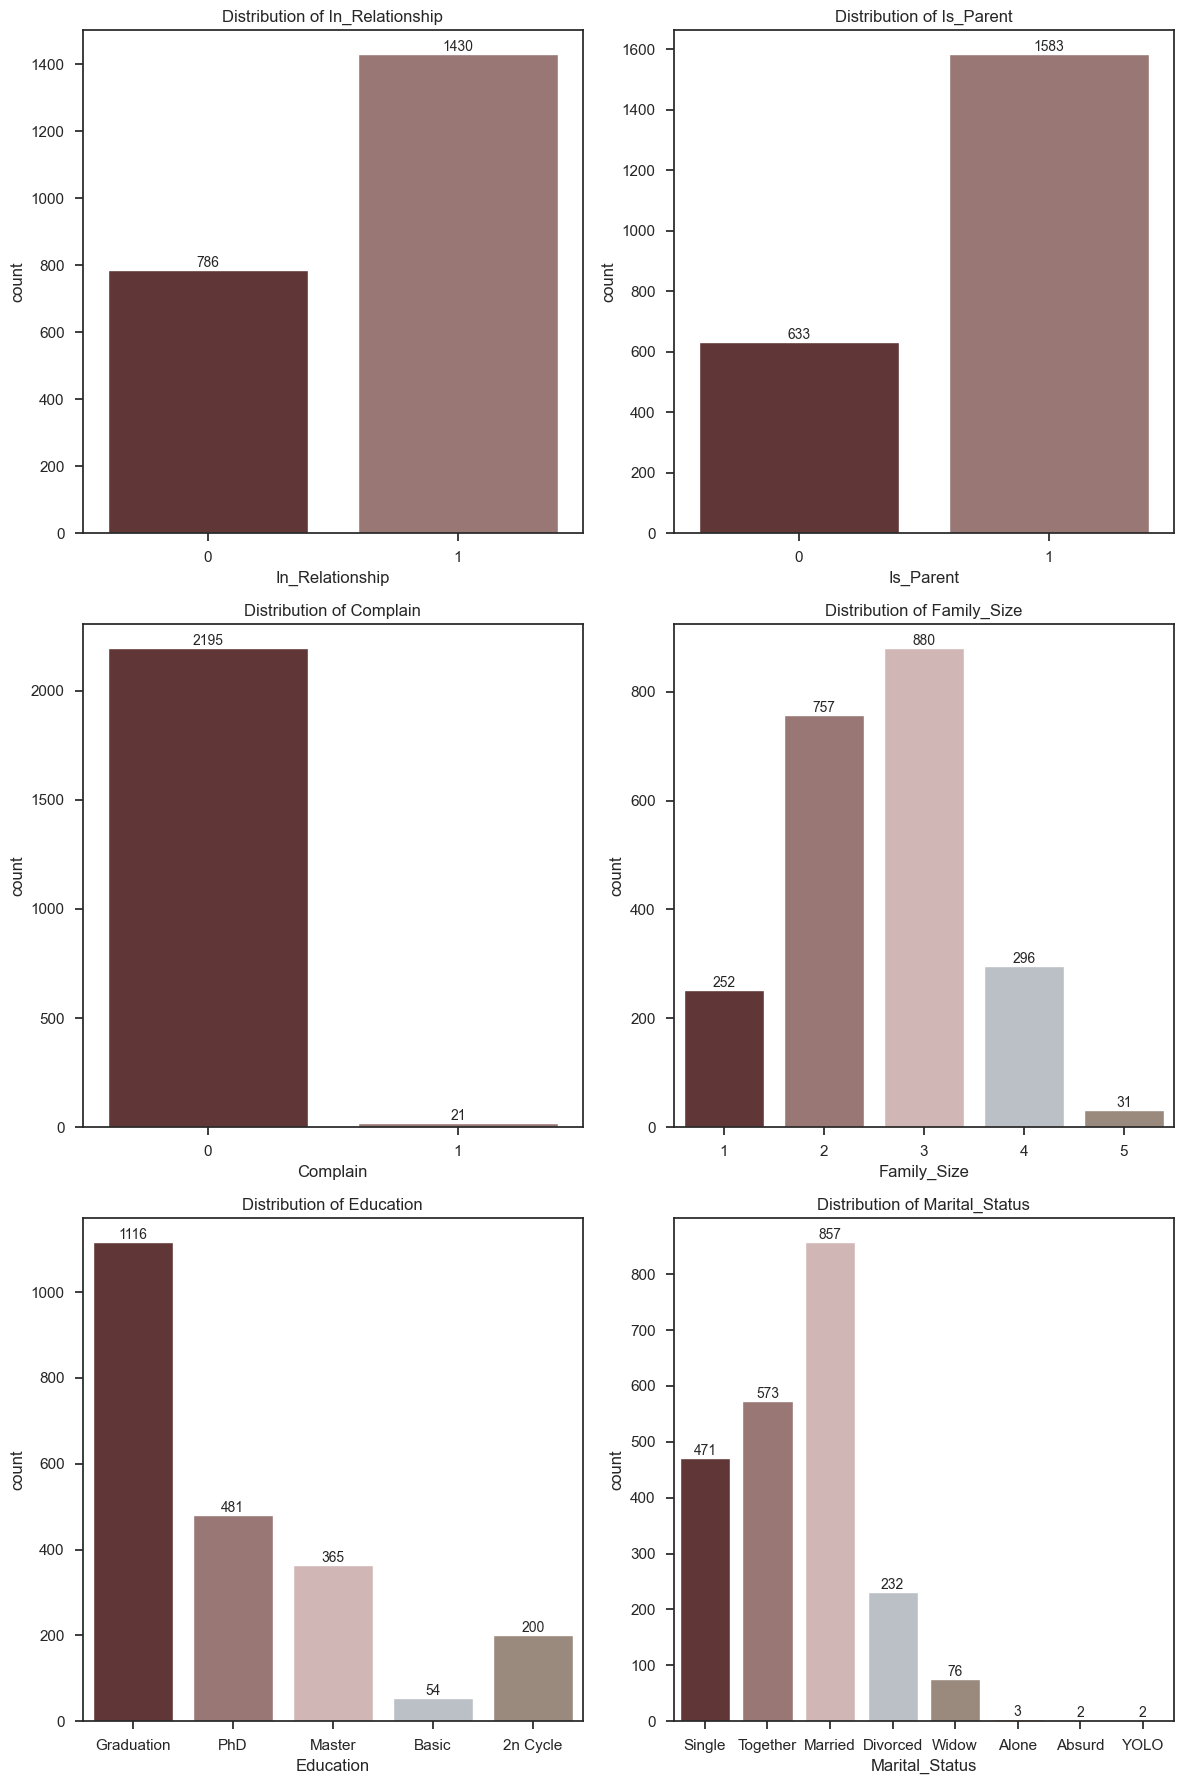

In [227]:
# Determine number of rows and columns of plot
n_cols = 2
n_rows = (len(categorical_features) + 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()

# Loop through columns and create bar plots
for idx, col in enumerate(categorical_features):
    ax = axes[idx]
    counts = data[col].value_counts()
    sns.countplot(x=col, data=data, palette=palette, ax=ax)
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.set_title(f"Distribution of {col}")

# Remove unused subplots if any
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Insights gained through this analysis**:

* Most Customers are in a relationship and have children
* Complains are very rare.
* Most Customers live in a household of 2 or three.
* Most Customers have a Education Level of Graduation followed by PhD and Master

## 5.2 Numerical Plots and Outlier Removel

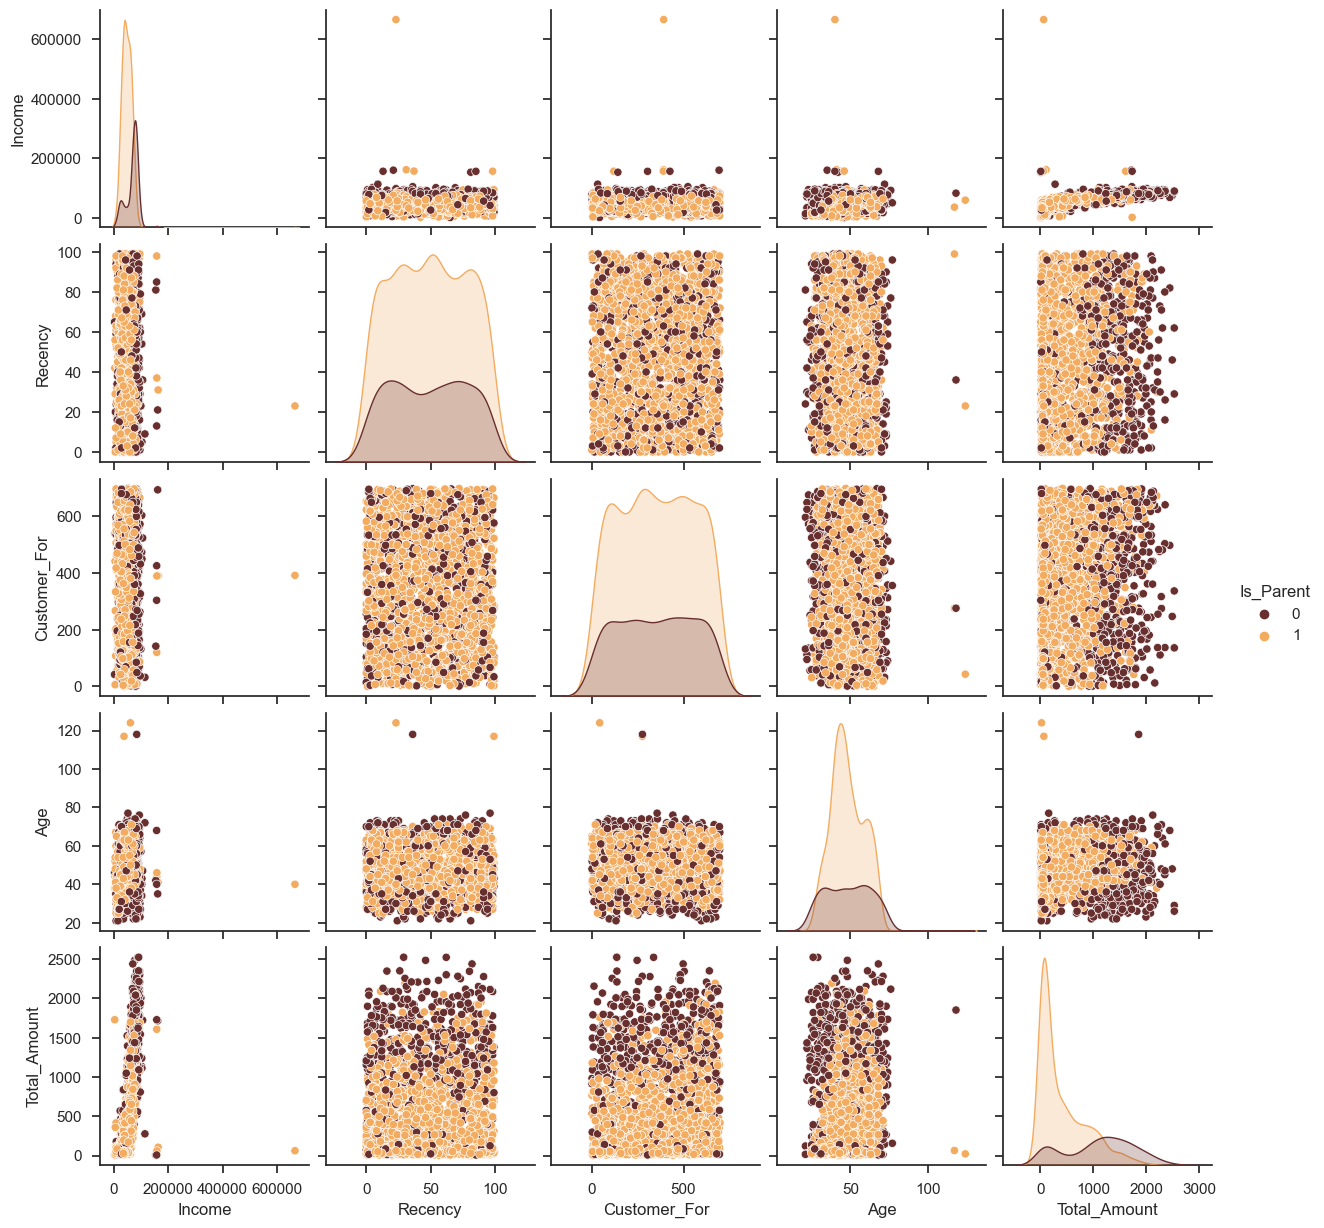

In [228]:
sns.pairplot(data=data, vars=numerical_features, hue="Is_Parent", palette=(["#682F2F", "#F3AB60"]))
plt.show()

There are some visible outliers in **Age**, **Income** and **Total_Amount** that should be removed before further analysis.  
I use **Mahalanobis Distance** to detect outliers outliers over these three dimensions.

In [229]:
selected_data = data[['Age', 'Income', 'Total_Amount']]
mean = np.mean(selected_data, axis=0)
covariance_matrix = np.cov(selected_data.values.T)

# Calculate Mahalanobis distance for each selected_data point
diff = selected_data - mean
mahalanobis_sq = np.dot(
    np.dot(diff, np.linalg.inv(covariance_matrix)), diff.T
).diagonal()

# Set a threshold for outliers
threshold = np.mean(mahalanobis_sq) * 3

# Filter out rows with Mahalanobis distance beyond the threshold
print(f"Number of samples before outlier removal: {len(data)}")
data = data[mahalanobis_sq < threshold]
print(f"Number of samples after outlier removal: {len(data)}")

Number of samples before outlier removal: 2216
Number of samples after outlier removal: 2177


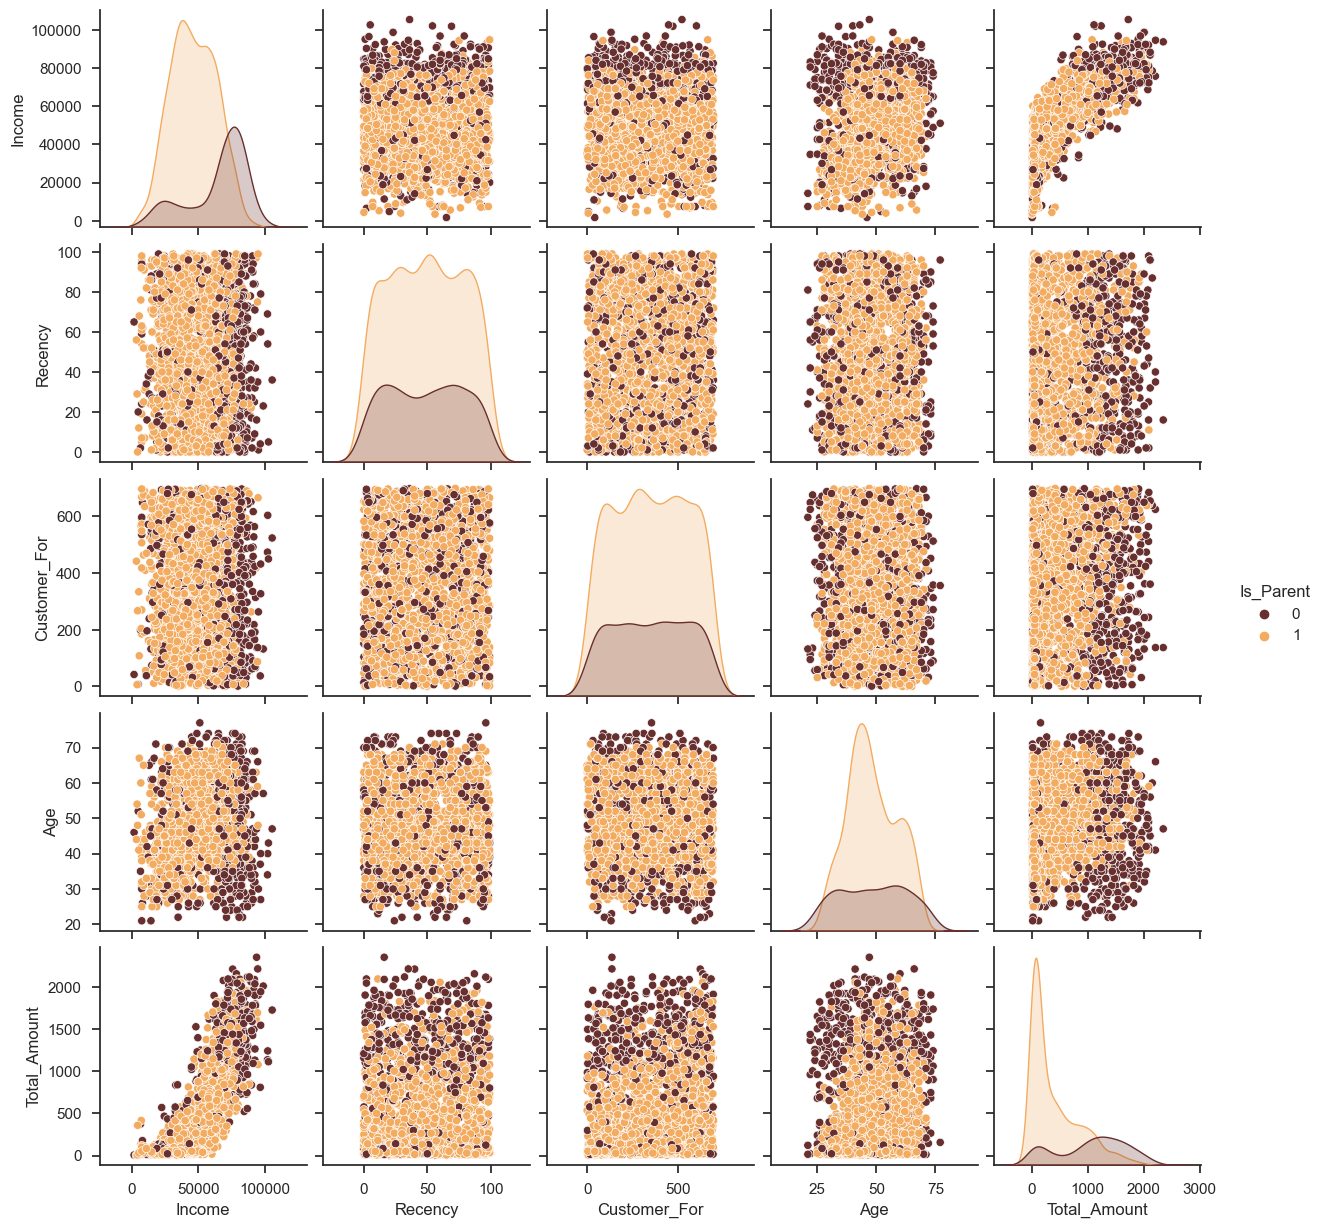

In [230]:
g = sns.pairplot(
    data=data,
    vars=numerical_features,
    hue="Is_Parent",
    palette=(["#682F2F", "#F3AB60"]),
)
#g.map_lower(sns.kdeplot, levels=4, color=".2")

plt.show()

**Insights gained through this analysis**:

* Income correlates strong with the total amount spend by that customer
* Non Parent Customers tend to earn more and also spend more

## 5.3 Analysis of Purchase types

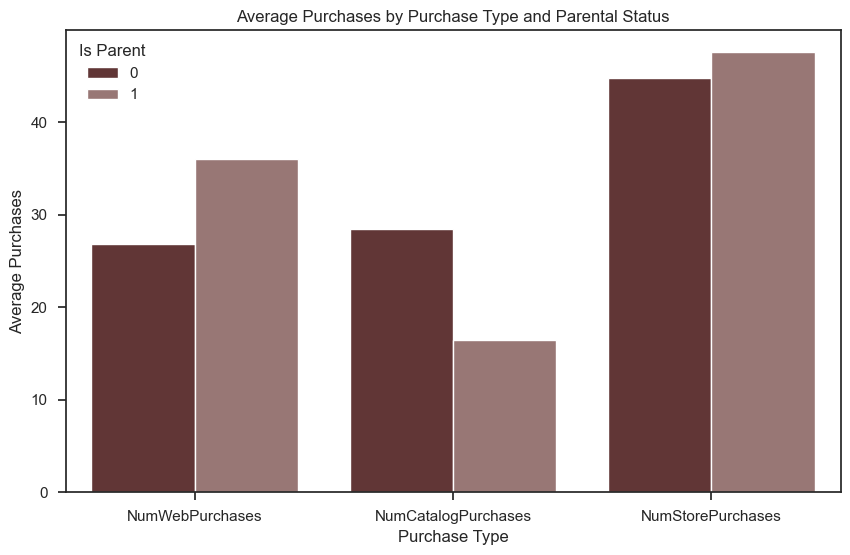

In [231]:
grouped_sum = data.groupby("Is_Parent")[
    ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
].sum()

grouped_sum["Total_Purchases"] = grouped_sum.sum(axis=1)

percentage_df = grouped_sum.div(grouped_sum["Total_Purchases"], axis=0) * 100

percentage_df = percentage_df.drop(columns="Total_Purchases").reset_index()
avg_purchases_by_type = pd.melt(
    percentage_df,
    id_vars=["Is_Parent"],
    var_name="Purchase_Type",
    value_name="Purchases",
)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Purchase_Type", y="Purchases", hue="Is_Parent", data=avg_purchases_by_type
)
plt.xlabel("Purchase Type")
plt.ylabel("Average Purchases")
plt.title("Average Purchases by Purchase Type and Parental Status")
plt.legend(title="Is Parent")
plt.show()

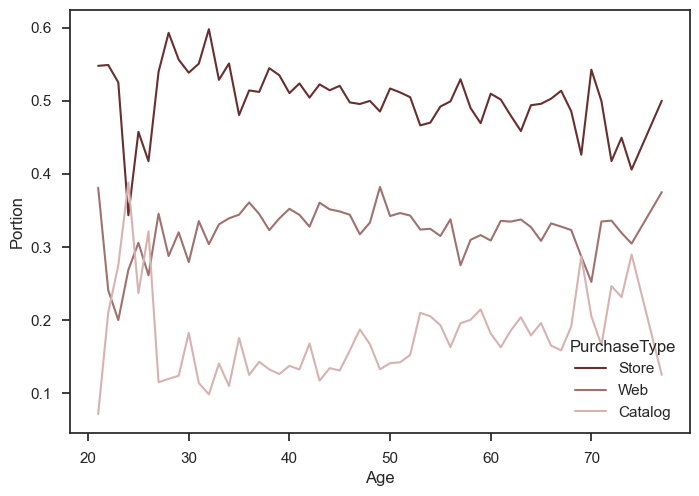

In [232]:
data["ratioStoreToOthers"] = data["NumStorePurchases"] / data["Total_Purchases"]
data["ratioWebToOthers"] = data["NumWebPurchases"] / data["Total_Purchases"]
data["ratioCatalogToOthers"] = data["NumCatalogPurchases"] / data["Total_Purchases"]
ratioStoreToOthers = data.groupby("Age")["ratioStoreToOthers"].mean()
ratioWebToOthers = data.groupby("Age")["ratioWebToOthers"].mean()
ratioCatalogToOthers = data.groupby("Age")["ratioCatalogToOthers"].mean()

# Step 3: Create a DataFrame with the grouped data
age_ratios = pd.DataFrame(
    {
        "Age": ratioStoreToOthers.index,
        "Store": ratioStoreToOthers.values,
        "Web": ratioWebToOthers.values,
        "Catalog": ratioCatalogToOthers.values,
    }
)

# Step 4: Plot the data using sns.lineplot
sns.lineplot(
    data=age_ratios.melt(id_vars="Age", var_name="PurchaseType", value_name="Portion"),
    x="Age",
    y="Portion",
    hue="PurchaseType",
)
data.drop(["ratioStoreToOthers", "ratioWebToOthers", "ratioCatalogToOthers"],axis=1, inplace=True)

## 5.4 Analysis of Accepted Campaigns

<Axes: xlabel='Purchase_Type', ylabel='Purchases'>

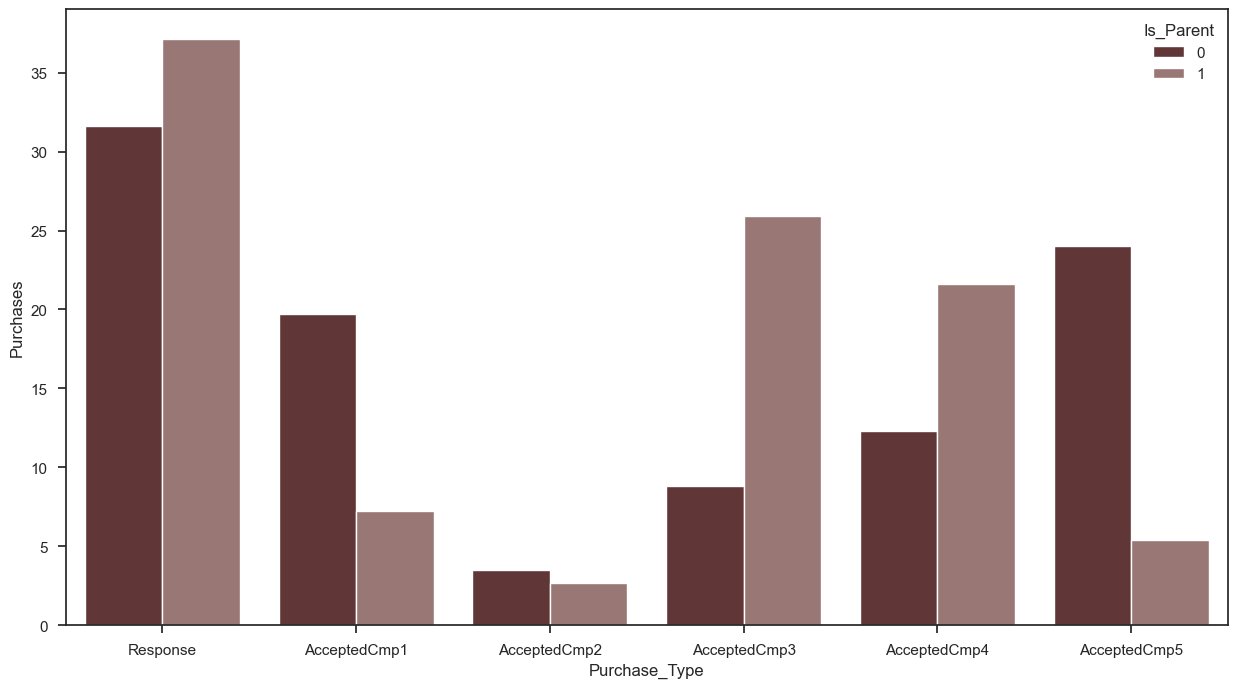

In [233]:
grouped_sum = data.groupby("Is_Parent")[
    campaign_features
].sum()

# Calculate total purchases per cluster
grouped_sum["Total_Campaign"] = grouped_sum.sum(axis=1)

# Calculate the percentage for each type of purchase
percentage_df = grouped_sum.div(grouped_sum["Total_Campaign"], axis=0) * 100

# Drop the TotalPurchases column as it's no longer needed
percentage_df = percentage_df.drop(columns="Total_Campaign").reset_index()
response_ratio_by_campaign = pd.melt(
    percentage_df,
    id_vars=["Is_Parent"],
    var_name="Purchase_Type",
    value_name="Purchases",
)
plt.figure(figsize=(15, 8))
sns.barplot(
    data=response_ratio_by_campaign, x="Purchase_Type", y="Purchases", hue="Is_Parent"
)

<Axes: xlabel='Age', ylabel='Mean Acceptance'>

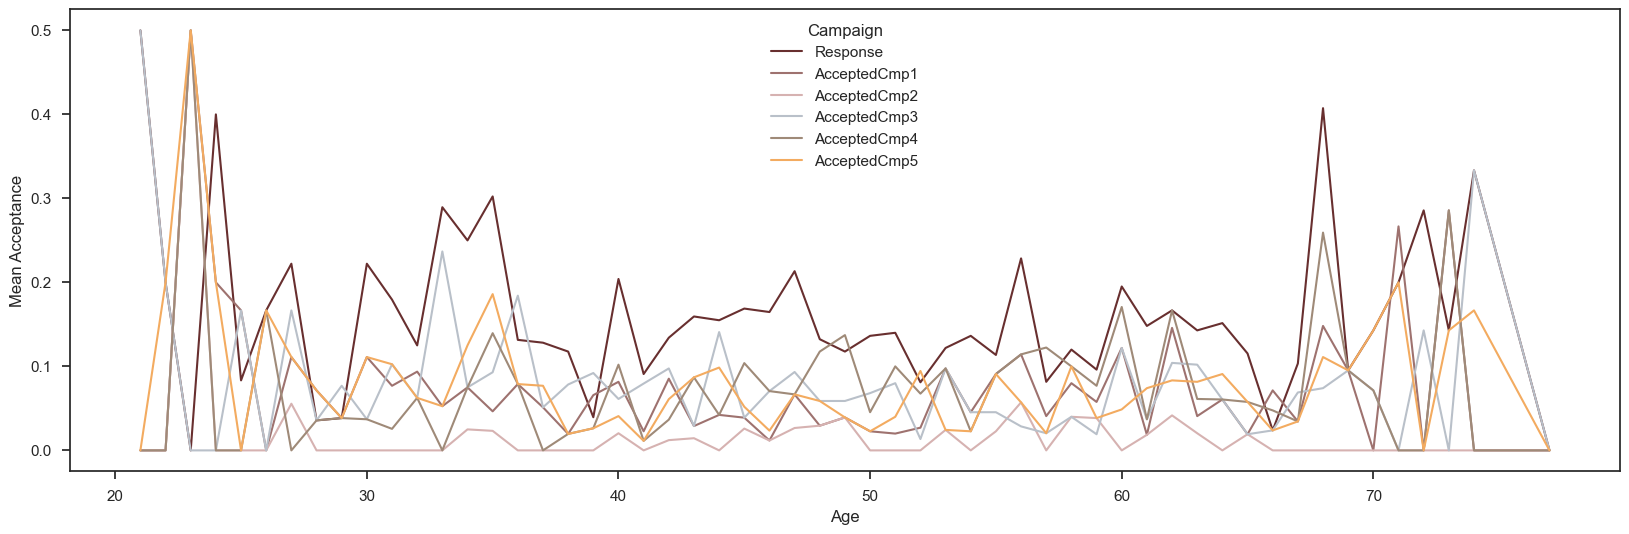

In [234]:
Total_Campaign_mean = data.groupby("Age")["Total_Campaign"].mean()
Response_mean = data.groupby("Age")["Response"].mean()
AcceptedCmp1_mean = data.groupby("Age")["AcceptedCmp1"].mean()
AcceptedCmp2_mean = data.groupby("Age")["AcceptedCmp2"].mean()
AcceptedCmp3_mean = data.groupby("Age")["AcceptedCmp3"].mean()
AcceptedCmp4_mean = data.groupby("Age")["AcceptedCmp4"].mean()
AcceptedCmp5_mean = data.groupby("Age")["AcceptedCmp5"].mean()

# Step 3: Create a DataFrame with the grouped data
age_campaign_acceptence = pd.DataFrame(
    {
        "Age": ratioStoreToOthers.index,
        "Response": Response_mean.values,
        "AcceptedCmp1": AcceptedCmp1_mean.values,
        "AcceptedCmp2": AcceptedCmp2_mean.values,
        "AcceptedCmp3": AcceptedCmp3_mean.values,
        "AcceptedCmp4": AcceptedCmp4_mean.values,
        "AcceptedCmp5": AcceptedCmp5_mean.values,
    }
)

plt.figure(figsize=(20, 6))
sns.lineplot(
    data=age_campaign_acceptence.melt(
        id_vars="Age", var_name="Campaign", value_name="Mean Acceptance"
    ),
    x="Age",
    y="Mean Acceptance",
    hue="Campaign",
)

The last campaign was the most successful and particular successful in the age range of 30-40.
Campaign 3 and 4 were more successful with parents while Campaign 1 and 5 are more successful with non-parents.

## 5.5 Analysis of Purchased Goods


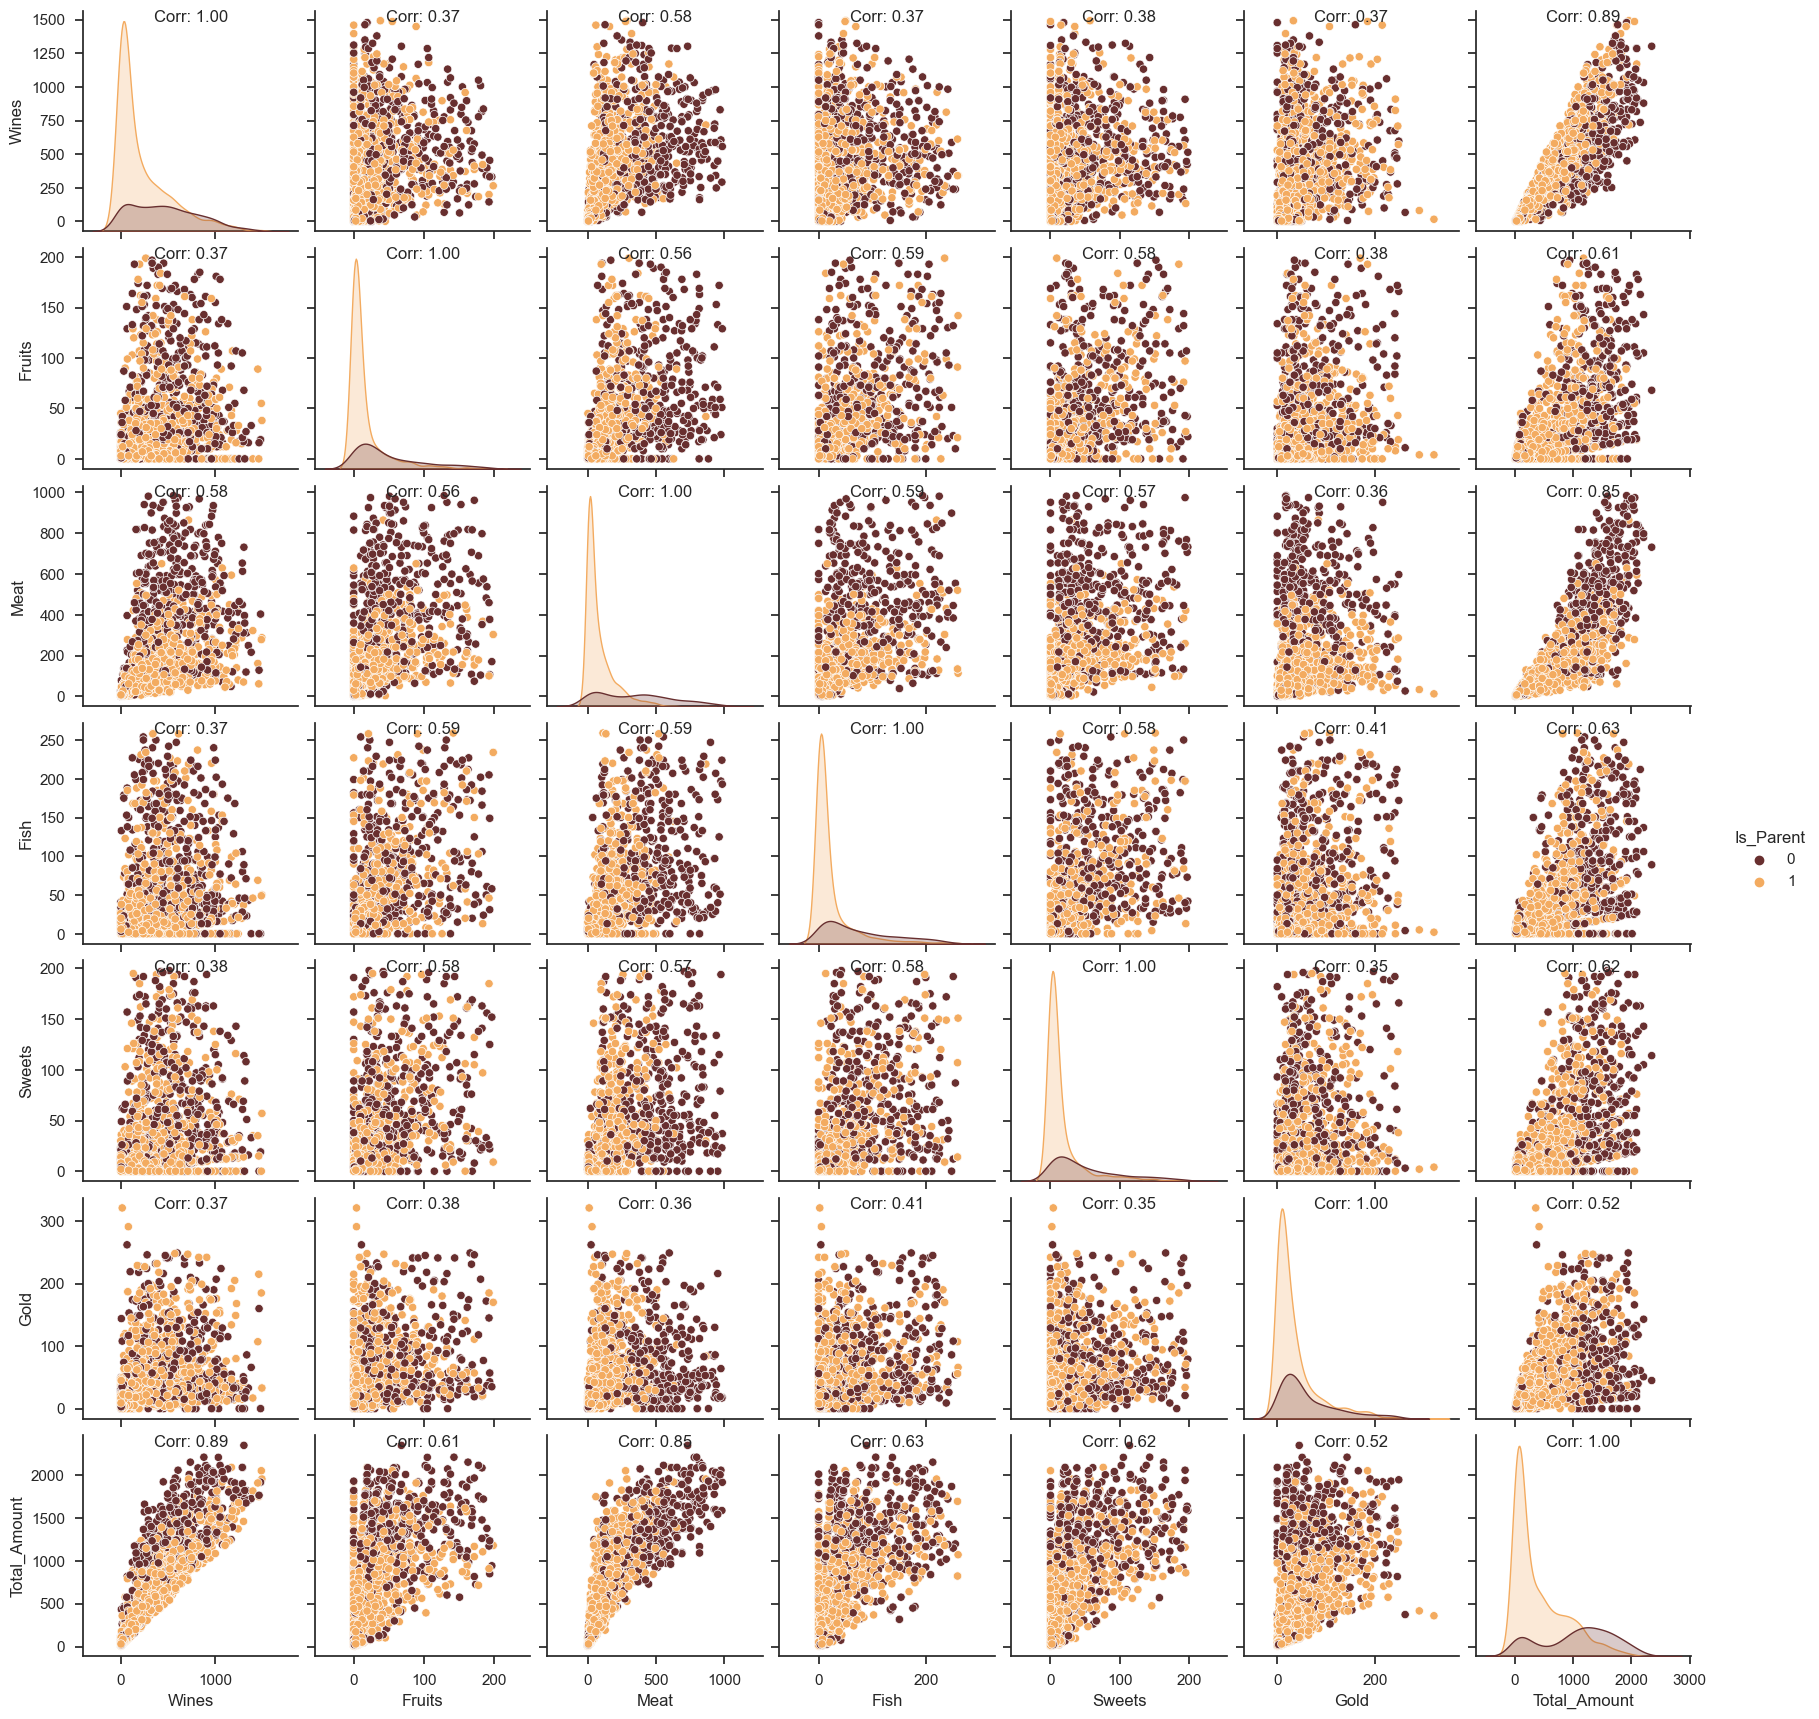

In [235]:
g = sns.pairplot(
    data=data,
    vars=amount_spend_features,
    hue="Is_Parent",
    palette=(["#682F2F", "#F3AB60"]),
)

# Iterate over the axes of the pairplot
for i, ax in enumerate(g.axes.flat):
    # Calculate correlation coefficient
    corr_coef = np.corrcoef(
        data[amount_spend_features[i % len(amount_spend_features)]],
        data[
            amount_spend_features[
                (i // len(amount_spend_features)) % len(amount_spend_features)
            ]
        ],
    )[0, 1]
    # Add correlation coefficient as annotation
    ax.annotate(
        f"Corr: {corr_coef:.2f}", xy=(0.5, 0.95), xycoords="axes fraction", ha="center"
    )

# Display the plot
plt.show()

<Axes: xlabel='Categories', ylabel='Amount spent'>

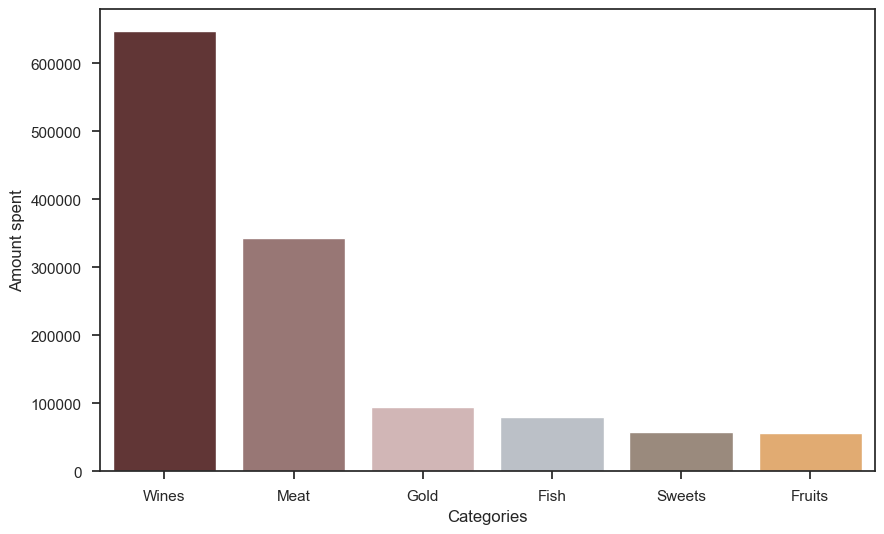

In [236]:
sum_wines = data["Wines"].sum()
sum_fruits = data["Fruits"].sum()
sum_meat = data["Meat"].sum()
sum_fish = data["Fish"].sum()
sum_sweets = data["Sweets"].sum()
sum_gold = data["Gold"].sum()

categories = [
    "Wines",
    "Meat",
    "Gold",
    "Fish",
    "Sweets", 
    "Fruits"
]
sums = [sum_wines, sum_meat, sum_gold, sum_fish, sum_sweets, sum_fruits]

# Create DataFrame for plotting
df = pd.DataFrame({"Categories": categories, "Amount spent": sums})

# Create bar plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Categories", y="Amount spent", palette=palette)

<Axes: xlabel='Purchase_Type', ylabel='Purchases'>

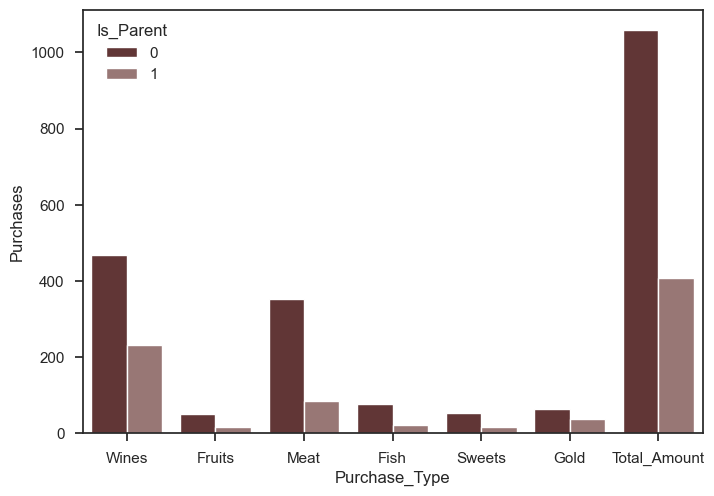

In [237]:
grouped_sum = data.groupby("Is_Parent")[amount_spend_features].mean()

df_long = pd.melt(
    grouped_sum.reset_index(),
    id_vars=["Is_Parent"],
    var_name="Purchase_Type",
    value_name="Purchases",
)
sns.barplot(data=df_long, x="Purchase_Type", y="Purchases", hue="Is_Parent")

Wine and Meat are the two most purchased products.
Parents tend to buy more gold, while non parents often buy meat.

## 5.6 Additional Plots

The following plot shows the Income between groups of customers with different education levels. It seems that customers with basic education earn much lesss than customers with higher education. The maximum here is not even 40.000 $. For the rest of education level it doesnt  seem to impact the Income so much.
The digram also shows the family size and it seems that most top earners have a low family size.

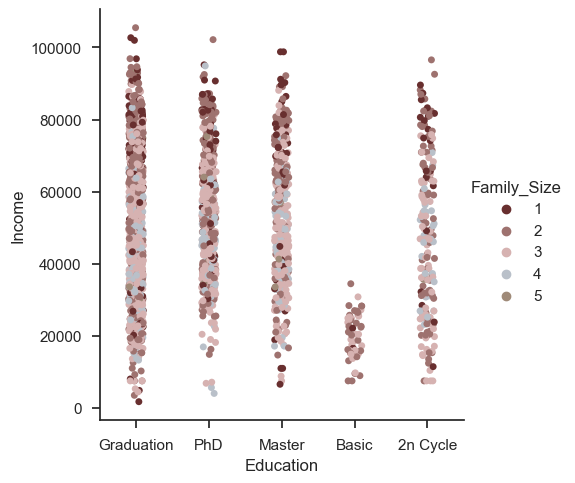

In [238]:
sns.catplot(
    kind="strip",
    data=data,
    x="Education",
    y="Income",
    hue="Family_Size",
    palette=palette,
    legend=True,
)

The following two diagrams confirm the trend that people with low family size and that are not parents tend to have a higher income and also spend more.

<Axes: xlabel='Is_Parent', ylabel='Income'>

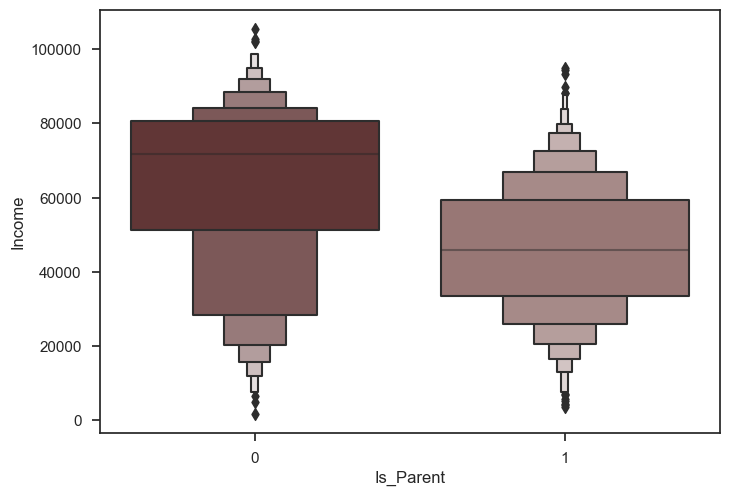

In [239]:
sns.boxenplot(data=data, y="Income", x="Is_Parent")

<Axes: xlabel='Is_Parent', ylabel='Total_Amount'>

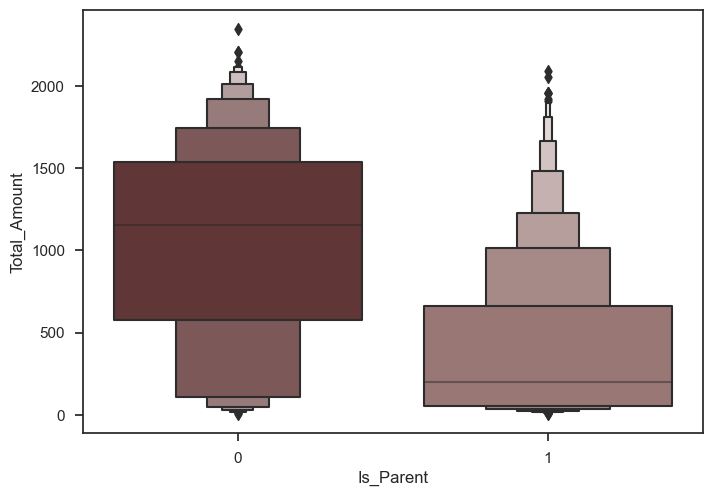

In [240]:
sns.boxenplot(data=data, y="Total_Amount", x="Is_Parent")

In [241]:
data["Is_Parent"].value_counts()
grouped = data.groupby("Is_Parent")["Total_Amount"].mean().reset_index()
is_parent_counts = (
    data["Is_Parent"]
    .value_counts()
    .reset_index()
    .sort_values("Is_Parent", ascending=True)
)
is_parent_counts.columns = ["Is_Parent", "Count"]

grouped = pd.concat([grouped, is_parent_counts.reset_index(drop=True)], axis=1)
grouped["sum_spent"] = grouped["Total_Amount"] * grouped["Count"]
grouped

Is_Parent  Total_Amount  Is_Parent  Count  sum_spent
0          0   1059.524917          0    602   637834.0
1          1    406.228571          1   1575   639810.0

# 6. Dimensionality Reduction

Before clustering the customers, some features might not be useful for the goal in mind.
I will remove the acceptance of campaigns because i dont want to analyse the campaign aceptance right now.
I will also remove the complain feature because they were only a few. 

In [242]:
ds = data.copy()

cols_del = [
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "Complain",
    "Response",
    "Education",
    "Marital_Status",
]

ds = ds.drop(cols_del, axis=1)

# Scaling of all features
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns=ds.columns).dropna()

For this clustering i want to focus on the amount spend on differnt items so i increase the weight of these features.

In [243]:
weight_adjusted_features = ["Wines", "Fruits", "Meat", "Fish", "Sweets", "Gold"]

for feature in weight_adjusted_features:
    scaled_ds[feature] *= 1.3

Lets use **Principle Component Analysis** to reduce the dimensionality.
I reduce the dimensionality so that the new dataset explains at least 90% of the variance of the original dataset.

In [244]:
pca = PCA(n_components=0.90)
pca.fit(scaled_ds)

# Transform the data using the fitted PCA
PCA_ds_095 = pd.DataFrame(pca.transform(scaled_ds))

# Add appropriate column names (optional)
PCA_ds_095.columns = [f"PC{i+1}" for i in range(PCA_ds_095.shape[1])]

# Display the description of the transformed data

explained_variance = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(
    explained_variance,
    columns=["Variance Explained"],
    index=[f"PC{i+1}" for i in range(len(explained_variance))],
)

explained_variance_df["Cumulative Variance Explained"] = explained_variance_df[
    "Variance Explained"
].cumsum()

print(explained_variance_df)

      Variance Explained  Cumulative Variance Explained
PC1             0.389406                       0.389406
PC2             0.113943                       0.503349
PC3             0.064753                       0.568102
PC4             0.057250                       0.625352
PC5             0.044193                       0.669545
PC6             0.038174                       0.707719
PC7             0.035578                       0.743297
PC8             0.033602                       0.776899
PC9             0.029370                       0.806270
PC10            0.026868                       0.833137
PC11            0.024323                       0.857460
PC12            0.023688                       0.881148
PC13            0.021604                       0.902753


The following plot shows the first three dimensions (that explain the most variance) of the transformed data. 

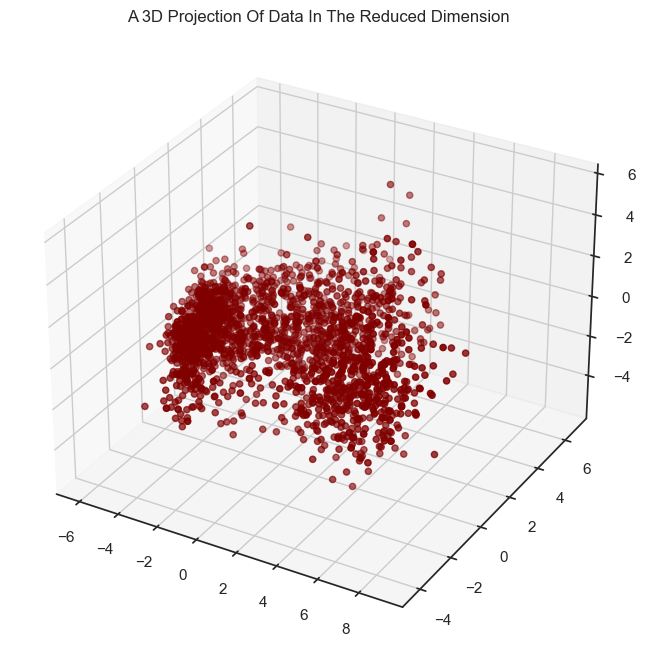

In [245]:
# To plot
x = PCA_ds_095["PC1"]
y = PCA_ds_095["PC2"]
z = PCA_ds_095["PC3"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c="maroon", marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# 7. Clustering

The **KElbowVisualizer** tests the clustering algorithm **KMeans** with different values for k (number of cluster) and plots the distortion score. Based on the Elbow method, the optimal value for k is marked. In this case we will use 4 clusters.

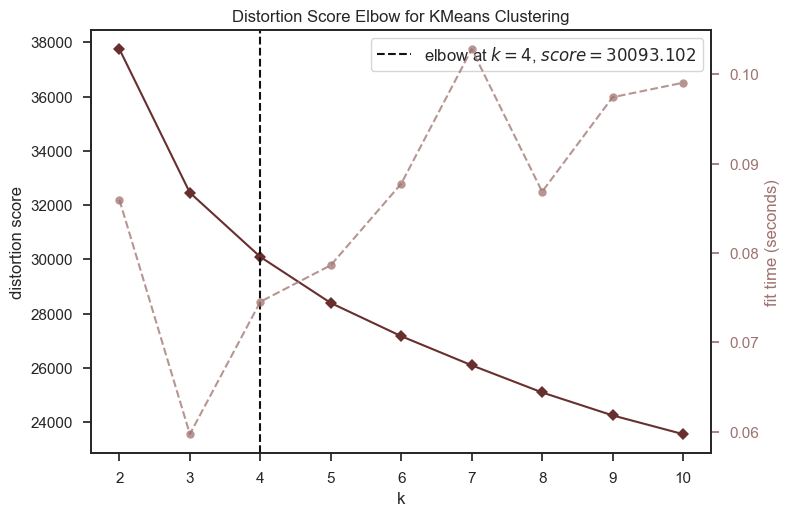

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [246]:
Elbow_M = KElbowVisualizer(KMeans(), k=10,n_init=10)
Elbow_M.fit(PCA_ds_095)
Elbow_M.show()

In [247]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds_095)
PCA_ds_095["Clusters"] = yhat_AC
# Adding the Clusters feature to the orignal dataframe.
data["Clusters"] = yhat_AC

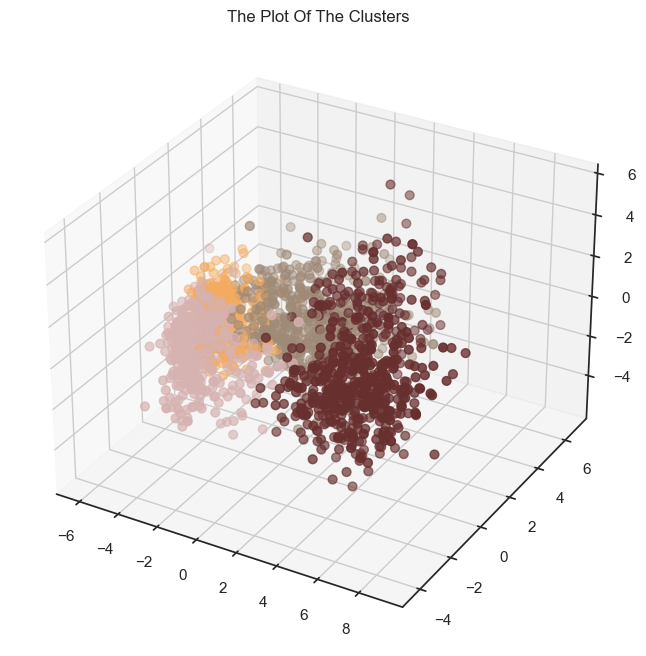

In [248]:
fig = plt.figure(figsize=(10, 8))
cmap = colors.ListedColormap(
    ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
)
ax = plt.subplot(111, projection="3d", label="bla")
ax.scatter(
    PCA_ds_095["PC1"],
    PCA_ds_095["PC2"],
    PCA_ds_095["PC3"],
    s=40,
    c=PCA_ds_095["Clusters"],
    marker="o",
    cmap=cmap,
)
ax.set_title("The Plot Of The Clusters")
plt.show()

The dataset was divided into 4 clusters.
On the 3-dimensional plot of the transformed data, the clusters are easily distinguishable and occupy differnt sections in space.
In the next part we will see how this translates over to the original dataset.

# 8. Profiling

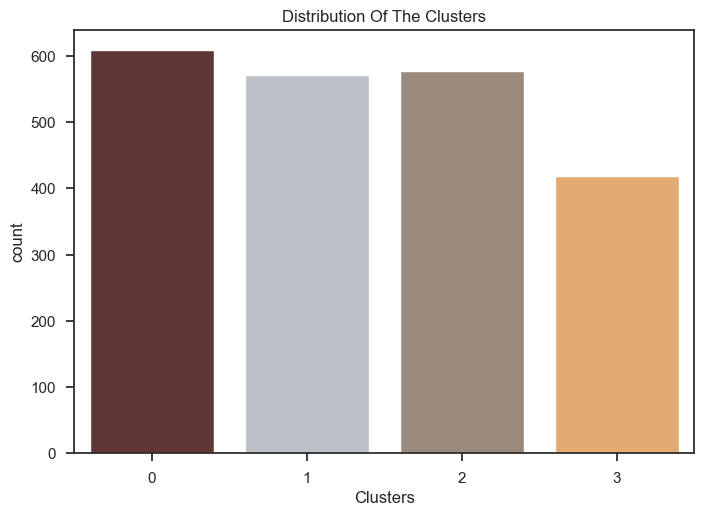

In [249]:
pal = ["#682F2F", "#B9C0C9", "#9F8A78", "#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette=pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

<Figure size 1800x1800 with 0 Axes>

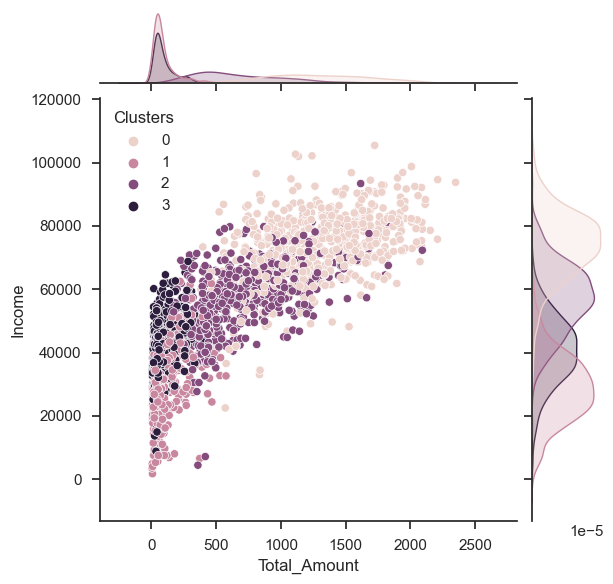

In [250]:
plt.figure(figsize=(18,18))
g = sns.jointplot(
    data=data,
    x=data["Total_Amount"],
    y=data["Income"],
    hue=data["Clusters"],
)

All clusters contain approximately the same number of customers.

The cluster membership seems to be affected by the Total_Amount spent and the Income:
* **Cluster 0:** Customers with high Income and high Total_Amount.
* **Cluster 1:** Customers with low Income and low Total_Amount.
* **Cluster 2:** Customers with medium-high Income and medium Total_Amount.
* **Cluster 3:** Customers with medium Income and low Total_Amount.

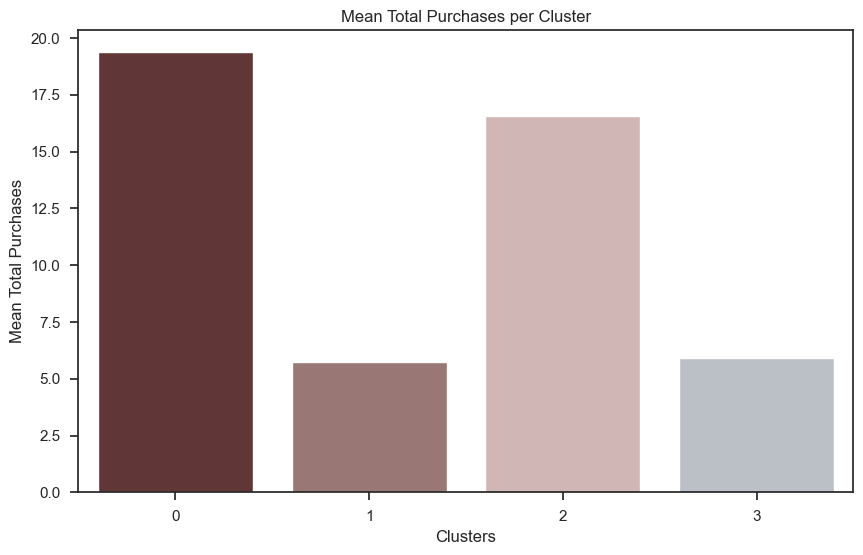

In [251]:
grouped = data.groupby("Clusters", as_index=False)["Total_Purchases"].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x="Clusters", y="Total_Purchases", data=grouped)
plt.xlabel("Clusters")
plt.ylabel("Mean Total Purchases")
plt.title("Mean Total Purchases per Cluster")
plt.show()

In [252]:
# mean spend per purchase in each cluster
grouped_amount = data.groupby("Clusters", as_index=False)["Total_Amount"].mean()
merged = grouped_amount.merge(grouped, on="Clusters")
merged["Amount_per_Purchase"] = merged["Total_Amount"] / merged["Total_Purchases"]
merged

Clusters  Total_Amount  Total_Purchases  Amount_per_Purchase
0         0   1289.308703        19.367816            66.569648
1         1     95.486865         5.751313            16.602619
2         2    687.671280        16.565744            41.511645
3         3     96.558473         5.926014            16.293999

Customer cluster with a higher Total Amount spent also have more purchases, but still spend much more in each individual purchase.

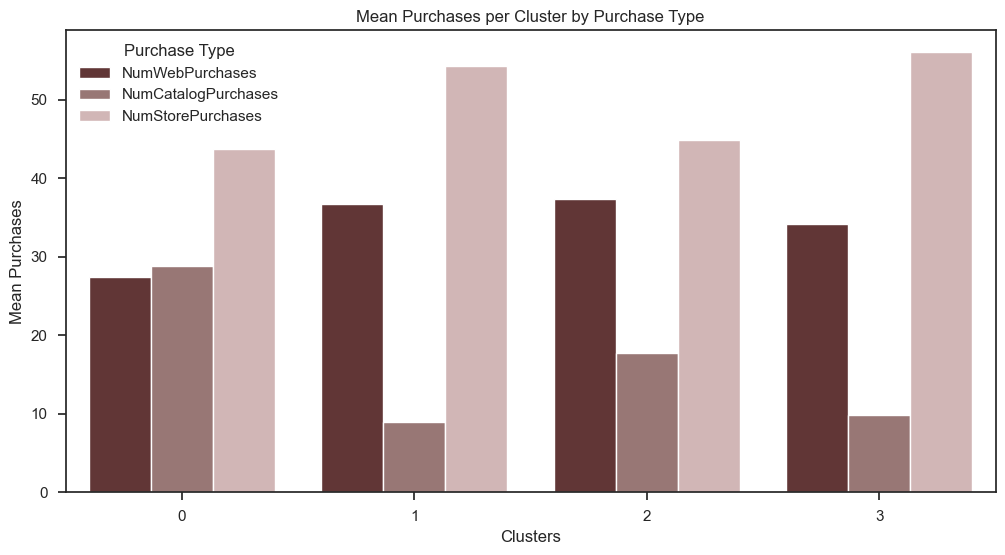

In [259]:
grouped_sum = data.groupby("Clusters")[
    ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]
].sum()

# Calculate total purchases per cluster
grouped_sum["TotalPurchases"] = grouped_sum.sum(axis=1)

# Calculate the percentage for each type of purchase
percentage_df = grouped_sum.div(grouped_sum["TotalPurchases"], axis=0) * 100

# Drop the TotalPurchases column as it's no longer needed
percentage_df = percentage_df.drop(columns="TotalPurchases").reset_index()

grouped_melted = percentage_df.melt(
    id_vars="Clusters",
    value_vars=["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"],
    var_name="PurchaseType",
    value_name="MeanPurchases",
)

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Clusters",
    y="MeanPurchases",
    hue="PurchaseType",
    data=grouped_melted,
)
plt.xlabel("Clusters")
plt.ylabel("Mean Purchases")
plt.title("Mean Purchases per Cluster by Purchase Type")
plt.legend(title="Purchase Type")
plt.show()

Cluster 0 uses the catalog for purchases much more than other clusters

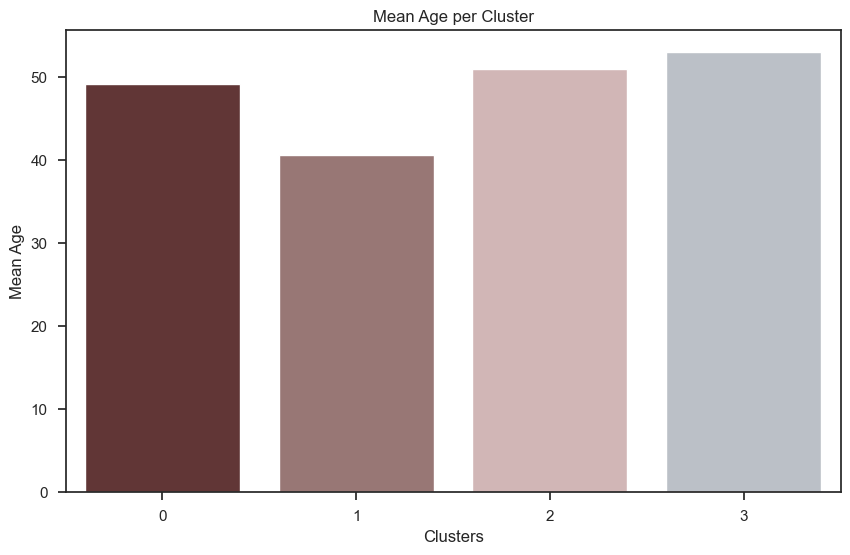

In [254]:
grouped_sum = data.groupby("Clusters")["Age"].mean()
grouped_sum_df = grouped_sum.reset_index()

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Clusters", y="Age", data=grouped_sum_df)

# Customize the plot
plt.xlabel("Clusters")
plt.ylabel("Mean Age")
plt.title("Mean Age per Cluster")
plt.show()

The mean age per cluster are similar

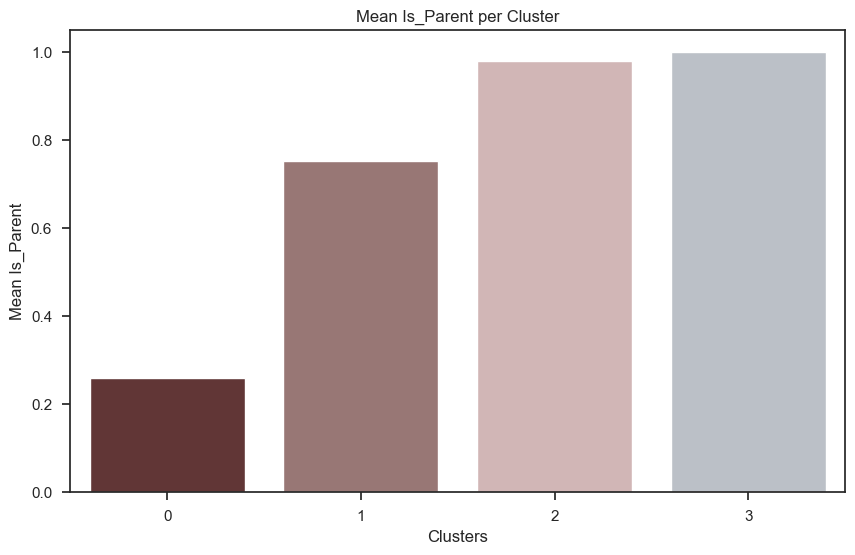

In [255]:
grouped_sum = data.groupby("Clusters")["Is_Parent"].mean()
grouped_sum_df = grouped_sum.reset_index()

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Clusters", y="Is_Parent", data=grouped_sum_df)

# Customize the plot
plt.xlabel("Clusters")
plt.ylabel("Mean Is_Parent")
plt.title("Mean Is_Parent per Cluster")
plt.show()

Customers from cluster 0 are much more likely to not have children than the other clusters

<Axes: xlabel='Clusters', ylabel='Purchases'>

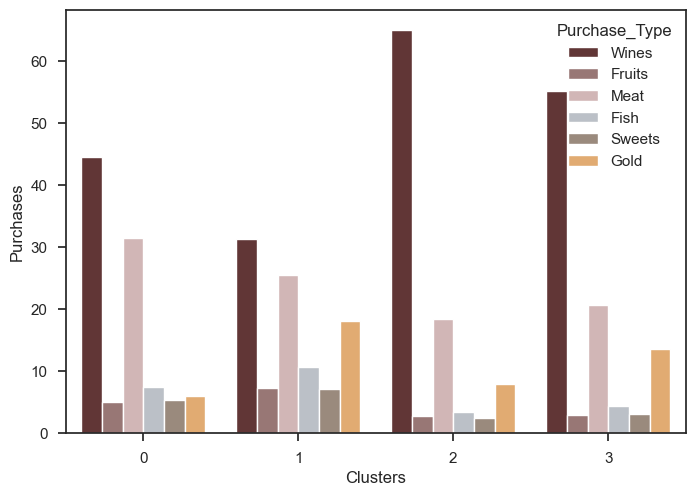

In [258]:
grouped_sum = data.groupby("Clusters")[amount_spend_features].mean()

for column in grouped_sum.columns:
    grouped_sum[column]=(grouped_sum[column]/grouped_sum["Total_Amount"])*100

df_long = pd.melt(
    grouped_sum.reset_index(),
    id_vars=["Clusters"],
    var_name="Purchase_Type",
    value_name="Purchases",
)

sns.barplot(
    df_long[df_long["Purchase_Type"] != "Total_Amount"],
    hue="Purchase_Type",
    x="Clusters",
    y="Purchases",
)

<Axes: xlabel='Clusters', ylabel='Acceptance'>

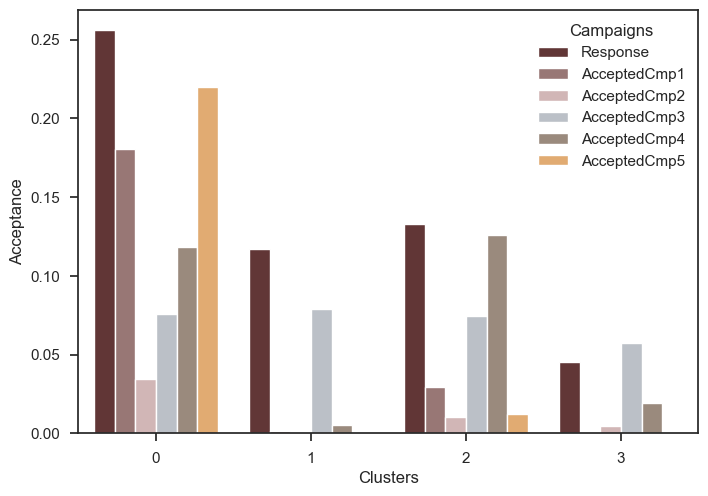

In [257]:
grouped_sum = data.groupby("Clusters")[campaign_features].mean()

df_long = pd.melt(
    grouped_sum.reset_index(),
    id_vars=["Clusters"],
    var_name="Campaigns",
    value_name="Acceptance",
)
sns.barplot(
    df_long,
    hue="Campaigns",
    x="Clusters",
    y="Acceptance",
)

# 9. Findings and Conclusion

General Findings:
- Customers with only basic education spend much less than other education levels.
- Customers without children spend about 3x more than customers with children.
- Overall Customers with and without children spend an equally amount.
- Wine and meat are the goods that customer spend the most on.
- Customers with higher income tend to buy more meat while customers with low income buy more gold.
- Most Purchases are done in stores, parents use the web more while customers with no children use the catalog more frequently.
- The last campaign was the most successful.
- Campaign 3 and 4 were more successful with parents while 1 and 5 were more successful with customers without children.

Cluster Profiles:
The customers were grouped into 4 clusters with roughly the same size with the same average age of about 50 (except cluster 1).   
Description of cluster 0:  
    - This cluster contains customers that do not have children, have a high income and spend much (especially on meat).   
    - They also use the Catalog for purchases more often than other clusters.  
    - This cluster is highly acceptive of campaigns.  
    - Perform high number of Purchases with high value  
Description of cluster 1:   
    - This cluster contains customers that mostly have children, have a low income and spend less.  
    - Their buying habits are the most uniform but they are buying more gold compared to other clusters.  
    - Perform low number of Purchases with low value  
    - Average age is about 40.  
Description of cluster 2:   
    - This cluster contains customers that have children, have a medium to high income and spend a medium amount.  
    - Perform high number of Purchases with medium value  
Description of cluster 3:   
    - This cluster contains customers that have children, have a medium income and spend less.  
    - Compared to other customer groups, they buy much gold.  
    - Perform low number of Purchases with low value  

Business Recommendations:
- Use the catalog more heavily to advertise meat and the web to advertise gold.
- The next campaign should be similar to the last one since it was the most succesful.  
Elements from campaign 3 and 4 can be used in the web to target parents while elements of 1 and 5 can be used in the catalog.



# 10. End